In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
i = 1 # choose which data set and corresponding sigma you want to use 
# (the second directory was simulated with beam spot variation of 1.5mm sigma in the z axis)
datadir = ["./Simulation_Output/", "./Simulation_Output_Beam_Spot/"][i]
data_sigma = [16.79e-3, 21.25e-3][i] # hit time sigma in ns 

mean = 2.05e-3 # hit time mean in ns

# list of the choices of hit time / corresponding sigma based on smearing
hit_time_types = ['adjusted_hit_time', 'adjusted_hit_time_30ps_gaussian', 'adjusted_hit_time_60ps_gaussian']
smearing_sigma = np.array([0, .03, .06])
overall_sigma = np.sqrt(data_sigma**2+smearing_sigma**2)

In [29]:
# pull truth and cluster data from parquet files

truthbib = pd.DataFrame()
recon2Dbib = pd.DataFrame()
truthsig = pd.DataFrame()
recon2Dsig = pd.DataFrame()

for file in os.listdir(datadir):
    if "labels" in file:
        if "bib" in file: 
            truthbib = pd.concat([truthbib,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dbib = pd.concat([recon2Dbib,pd.read_parquet(f"{datadir}{file}")])
        elif "sig" in file: 
            truthsig = pd.concat([truthsig,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dsig = pd.concat([recon2Dsig,pd.read_parquet(f"{datadir}{file}")])

In [30]:
print(f"# of bib clusters: {len(truthbib)}\n# of sig clusters {len(truthsig)}")
print(f"Total # of clusters: {len(truthbib)+len(truthsig)}")

# of bib clusters: 34550
# of sig clusters 38446
Total # of clusters: 72996


In [31]:
# View directly calculated mean and standard deviation - they are slightly different from what is assumed earlier
# (Not sure which to use or how much it matters)
i=1
print(f"For {hit_time_types[i]}:\nMean: {round(np.mean(truthsig[hit_time_types[i]])*1000,2)} ps, Standard Deviation: {round(np.std(truthsig[hit_time_types[i]])*1000,2)} ps")

For adjusted_hit_time_30ps_gaussian:
Mean: 2.09 ps, Standard Deviation: 36.6 ps


In [32]:
# View header of truth dataframe, to see info that can be accessed
truthsig.head()

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,pt,z-global,hit_time,PID,cotAlpha,cotBeta,y-midplane,x-midplane,adjusted_hit_time,adjusted_hit_time_30ps_gaussian,adjusted_hit_time_60ps_gaussian
0,5.220202,8.833484,50.0,13.526906,-5.815156,-79.856583,3082.0,-2.11019,80.068207,4.400490,0.10240,-13.0,-0.16939,0.07282,8.833484,5.220202,0.001260,0.054028,0.025402
1,-57.008575,16.801975,50.0,2.205049,-0.345567,-2.772078,20316.0,-3.91197,2.115810,26.573721,0.12951,13.0,-0.79545,0.12466,16.801975,-57.008575,-0.004172,-0.020521,0.039644
2,-37.854046,-34.314388,50.0,2.206462,0.744530,-2.691333,4808.0,8.14806,2.115810,27.202780,0.13290,13.0,-0.81984,-0.27664,-34.314388,-37.854046,-0.002183,-0.011823,0.010780
3,39.062775,1.416621,50.0,-30.544853,3.250319,-18.759775,15555.0,5.27398,14.418530,46.363941,0.19319,13.0,1.62821,-0.17326,1.416621,39.062775,0.008985,0.058474,-0.003131
4,24.946722,-18.124542,50.0,-39.150837,-5.813652,-55.426182,3696.0,-3.07140,42.205910,22.103210,0.12374,-13.0,0.70636,0.10489,-18.124542,24.946722,-0.000557,-0.003787,-0.044802


In [33]:
# Code for ROC curve

"""
This function generates the false positive rate and true positive rate for a given hit time type and cut size 

If a hit_time is within mu +/- cut it is accepted, otherwise it is rejected
"""
def getROCCurveInfo(cut, hit_time_type):
    false_positives = 0

    for hit_time in truthbib[hit_time_type]:
        if hit_time > mean-cut and hit_time < mean+cut:
            false_positives += 1

    true_positives = 0
    
    for hit_time in truthsig[hit_time_type]:
        if hit_time > mean-cut and hit_time < mean+cut:
            true_positives += 1

    true_positive_rate = true_positives/len(truthsig[hit_time_type])    
    false_positive_rate = false_positives/len(truthbib[hit_time_type])

    return true_positive_rate, false_positive_rate


"""
This function generates a ROC curve which is the fase positive rate vs the true positive rate 
"""
def generateROCCurve(hit_time_type):
    
    # generate a list of potential cut sizes
    cuts = np.arange(0, 2.5, 0.005) # [ps]
    
    # arrays to hold true positive and false positive rates
    tpr = []
    fpr = []

    # for each cut, get the corresponding true positive and false positive rates
    for cut in cuts:
        true_positive, false_positive = getROCCurveInfo(cut, hit_time_type)

        tpr.append(true_positive)
        fpr.append(false_positive)

    fpr = np.array(fpr)
    tpr = np.array(tpr) 

    # Get the difference of the two rates (we want to maximize true positive and minimize false positive)
    diff = tpr-fpr 
    # Get the index corresponding to the "best" cut
    max_index = np.argmax(diff)
    
    print(f"For {hit_time_type}:")
    print(f"Max val = {max(diff)}")
    print(f"Ideal cut value is {cuts[max_index]}\n")

    return tpr, fpr

For adjusted_hit_time:
Max val = 0.9772770227536614
Ideal cut value is 0.015

For adjusted_hit_time_30ps_gaussian:
Max val = 0.9310305303139863
Ideal cut value is 0.085

For adjusted_hit_time_60ps_gaussian:
Max val = 0.889602436721628
Ideal cut value is 0.155



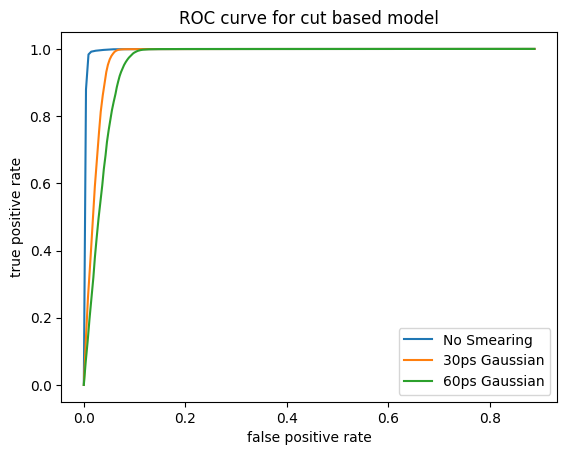

In [34]:
# Get ROC curves for each level of smearing on the hit time

tpr1, fpr1 = generateROCCurve(hit_time_types[0])

tpr2, fpr2 = generateROCCurve(hit_time_types[1])

tpr3, fpr3 = generateROCCurve(hit_time_types[2]) 

plt.plot(fpr1, tpr1, label='No Smearing')
plt.plot(fpr2, tpr2,label='30ps Gaussian')
plt.plot(fpr3, tpr3,label='60ps Gaussian')
plt.title("ROC curve for cut based model")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc='best')
plt.show()

In [35]:
"""
This function simulates a cut and returns numpy arrays defining the remaining signal and remaining BIB, 
and the signal efficiency and background rejection for a given hit time type
"""
def cut(hit_time_type, cut):
    bib_hit_time = truthbib[hit_time_type]
    signal_hit_time = truthsig[hit_time_type]

    false_positive = 0
    true_negative = 0

    remaining_bib = np.full(len(bib_hit_time), False)
    
    i = 0
    for time in bib_hit_time:
        if time > -cut and time < cut:
            false_positive += 1
            remaining_bib[i] = True
        else:
            true_negative += 1
        i += 1

    remaining_sig = np.full(len(signal_hit_time), False)

    false_negative = 0
    true_positive = 0

    i = 0 
    for time in signal_hit_time:
        if time > -cut and time < cut:
            true_positive += 1
            remaining_sig[i] = True
        else:
            false_negative += 1
        i += 1

    signal_efficiency = true_positive/len(signal_hit_time)

    background_rejection = true_negative/len(bib_hit_time)

    print(f"For {hit_time_type}:\nSignal Efficiency: {round(signal_efficiency*100, 2)} %\nBackground Rejection: {round(background_rejection*100, 2)} %")

    return remaining_bib, remaining_sig, round(signal_efficiency*100, 2), round(background_rejection*100, 2)

In [36]:
# cut   
i=2 # choose the level of smearing
remaining_bib, remaining_sig, signal_efficiency, background_rejection = cut(hit_time_types[i], 3*smearing_sigma[i])

For adjusted_hit_time_60ps_gaussian:
Signal Efficiency: 99.65 %
Background Rejection: 88.81 %


For adjusted_hit_time_30ps_gaussian:
Signal Efficiency: 99.58 %
Background Rejection: 93.41 %


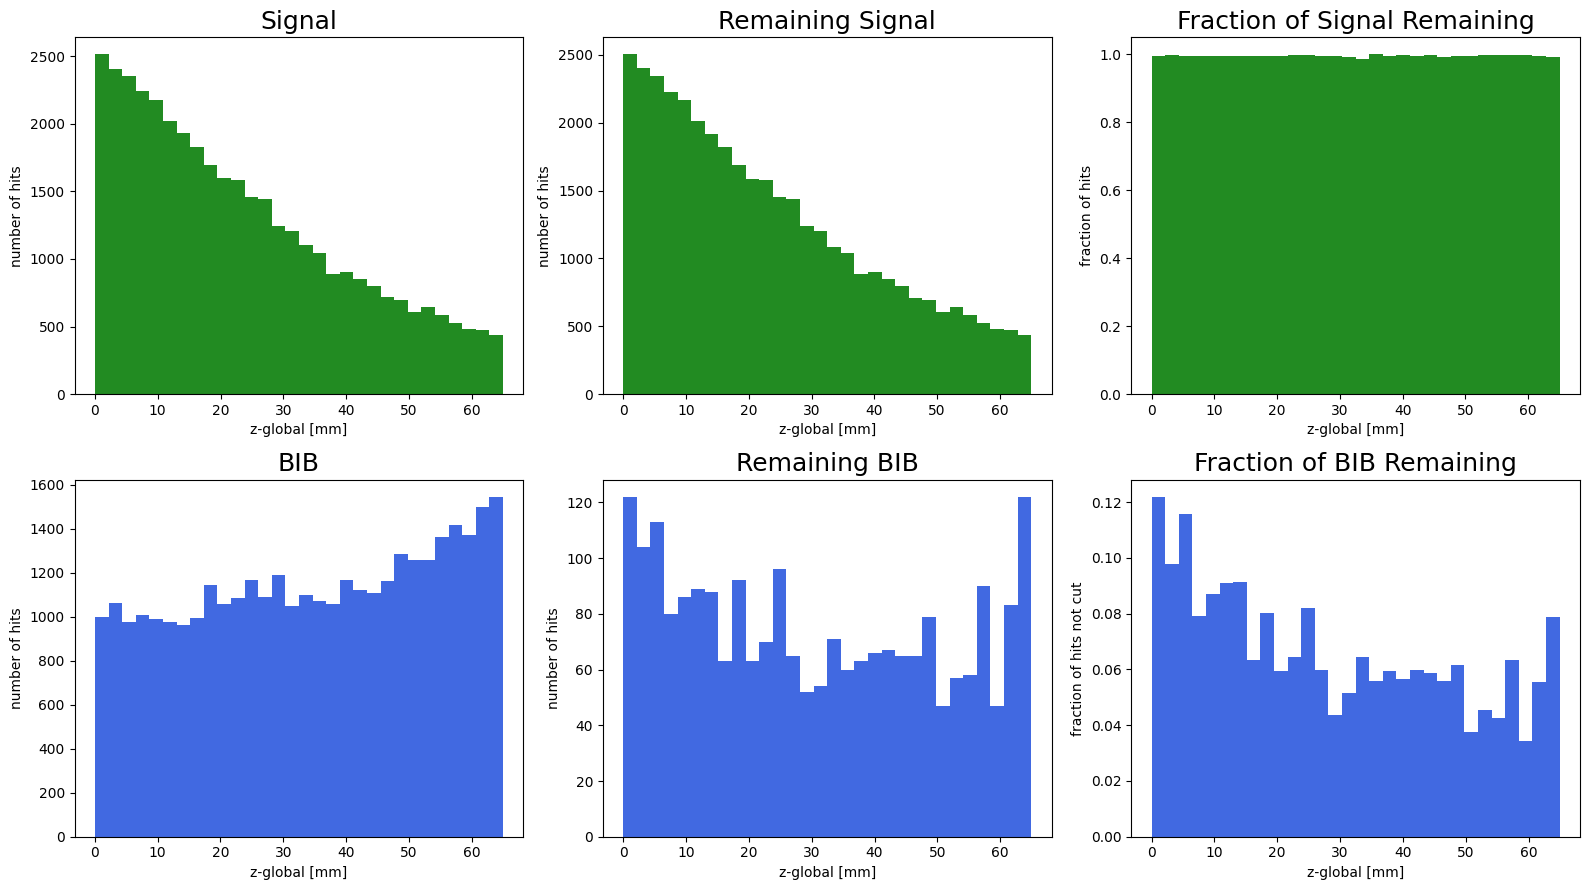

In [43]:
# cut   

i=1
remaining_bib, remaining_sig, signal_efficiency, background_rejection = cut(hit_time_types[i], 3*smearing_sigma[i])

remaining_bib_truth = truthbib[remaining_bib]
remaining_sig_truth = truthsig[remaining_sig]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16,9))

n1, bins, patches = ax[0,0].hist(truthsig['z-global'], bins=30, color = 'forestgreen')
ax[0,0].set_ylabel("number of hits")
ax[0,0].set_xlabel("z-global [mm]")
ax[0,0].set_title("Signal",fontsize=18)

n2, bins, patches = ax[0,1].hist(remaining_sig_truth['z-global'], bins=30, color = 'forestgreen')
ax[0,1].set_ylabel("number of hits")
ax[0,1].set_xlabel("z-global [mm]")
ax[0,1].set_title("Remaining Signal",fontsize=18)

width = bins[1]-bins[2]

ax[0,2].bar(bins[1:],n2/n1, width=width, bottom=None, align='edge', label='fraction of signal not cut', color = 'forestgreen')
ax[0,2].set_ylabel("fraction of hits")
ax[0,2].set_xlabel("z-global [mm]")
ax[0,2].set_title("Fraction of Signal Remaining",fontsize=18)


n1, bins, patches = ax[1,0].hist(truthbib['z-global'], bins=30, color = 'royalblue')
ax[1,0].set_ylabel("number of hits")
ax[1,0].set_xlabel("z-global [mm]")
ax[1,0].set_title("BIB",fontsize=18)

n2, bins, patches = ax[1,1].hist(remaining_bib_truth['z-global'], bins=30, color = 'royalblue')
ax[1,1].set_ylabel("number of hits")
ax[1,1].set_xlabel("z-global [mm]")
ax[1,1].set_title("Remaining BIB",fontsize=18)

ax[1,2].bar(bins[1:],n2/n1, width=width, bottom=None, align='edge', label='fraction of signal not cut', color = 'royalblue')
ax[1,2].set_ylabel("fraction of hits not cut")
ax[1,2].set_xlabel("z-global [mm]")
ax[1,2].set_title("Fraction of BIB Remaining",fontsize=18)

fig.tight_layout()  

plt.show()

For adjusted_hit_time_30ps_gaussian:
Signal Efficiency: 99.58 %
Background Rejection: 93.41 %


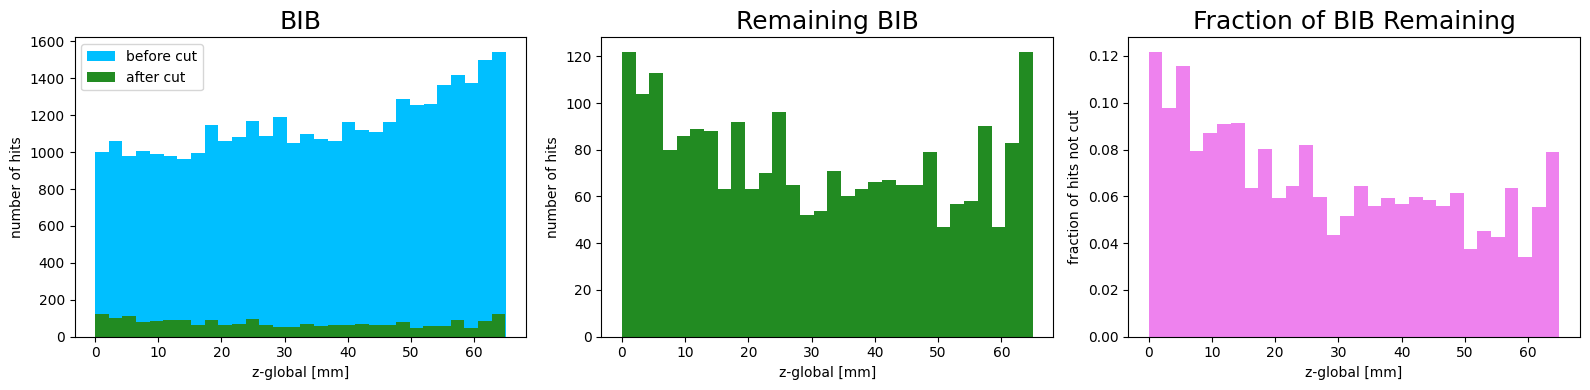

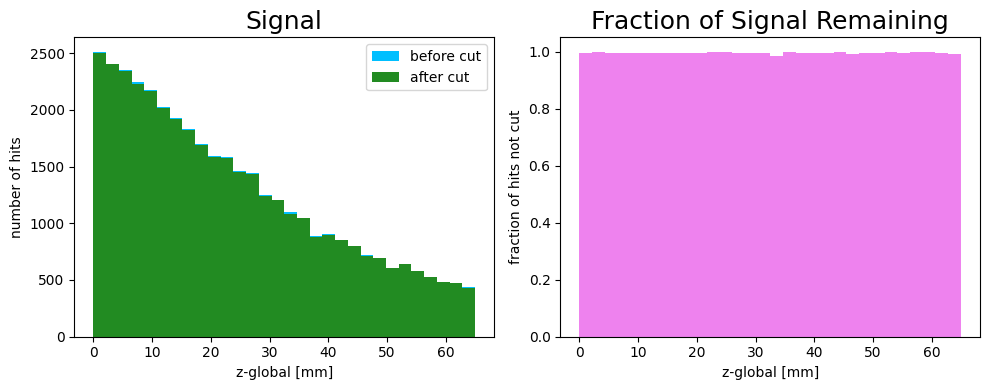

In [44]:
# cut   

i=1
remaining_bib, remaining_sig, signal_efficiency, background_rejection = cut(hit_time_types[i], 3*smearing_sigma[i])

remaining_bib_truth = truthbib[remaining_bib]
remaining_sig_truth = truthsig[remaining_sig]

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,4))

n1, bins, patches = ax[0].hist(truthbib['z-global'], bins=30, color = 'deepskyblue', label='before cut')
n2, bins, patches = ax[0].hist(remaining_bib_truth['z-global'], bins=30, color = 'forestgreen', label='after cut')
ax[0].set_ylabel("number of hits")
ax[0].set_xlabel("z-global [mm]")
ax[0].set_title("BIB",fontsize=18)
ax[0].legend()

ax[1].hist(remaining_bib_truth['z-global'], bins=30, color = 'forestgreen')
ax[1].set_ylabel("number of hits")
ax[1].set_xlabel("z-global [mm]")
ax[1].set_title("Remaining BIB",fontsize=18)

ax[2].bar(bins[1:],n2/n1, width=width, bottom=None, align='edge', label='fraction of signal not cut', color = 'violet')
ax[2].set_ylabel("fraction of hits not cut")
ax[2].set_xlabel("z-global [mm]")
ax[2].set_title("Fraction of BIB Remaining",fontsize=18)

fig.tight_layout()  

plt.show()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

n1, bins, patches = ax[0].hist(truthsig['z-global'], bins=30, color = 'deepskyblue', label='before cut')
n2, bins, patches = ax[0].hist(remaining_sig_truth['z-global'], bins=30, color = 'forestgreen', label='after cut')
ax[0].set_ylabel("number of hits")
ax[0].set_xlabel("z-global [mm]")
ax[0].set_title("Signal",fontsize=18)
ax[0].legend()

ax[1].bar(bins[1:],n2/n1, width=width, bottom=None, align='edge', label='fraction of signal not cut', color = 'violet')
ax[1].set_ylabel("fraction of hits not cut")
ax[1].set_xlabel("z-global [mm]")
ax[1].set_title("Fraction of Signal Remaining",fontsize=18)

fig.tight_layout()  

plt.show()

In [45]:
# These fuctions get the x and y profiles and x and y sizes of the cluster

def getYProfiles(clusters):
    profiles = np.sum(clusters, axis = 2)
    totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles/totalCharge

def getAverageYProfile(clusters):
    profiles=getYProfiles(clusters)
    return np.mean(profiles, axis=0)

def getClusterYSizes(clusters):
    profiles=getYProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterYSize(clusters):
    clusterSizes = getClusterYSizes(clusters)
    return np.mean(clusterSizes)

def getXProfiles(clusters):
    profiles = np.sum(clusters, axis = 1)
    totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles/totalCharge

def getAverageXProfile(clusters):
    profiles=getXProfiles(clusters)
    return np.mean(profiles, axis=0)

def getClusterXSizes(clusters):
    profiles=getXProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterXSize(clusters):
    clusterSizes = getClusterXSizes(clusters)
    return np.mean(clusterSizes)

In [46]:
# First convert to a numpy array of the correct shape

clustersbib = recon2Dbib.to_numpy().reshape(recon2Dbib.shape[0],13,21)
clusterssig = recon2Dsig.to_numpy().reshape(recon2Dsig.shape[0],13,21)

all_clusters = np.concatenate([clustersbib, clusterssig])

remainingclustersbib = recon2Dbib[remaining_bib].to_numpy().reshape(recon2Dbib[remaining_bib].shape[0],13,21)
remainingclusterssig = recon2Dsig[remaining_sig].to_numpy().reshape(recon2Dsig[remaining_sig].shape[0],13,21)

all_remaining_clusters = np.concatenate([remainingclustersbib, remainingclusterssig])

In [47]:
print(f"Change in cluster x-size after cut: {getAverageClusterXSize(all_clusters)-getAverageClusterXSize(all_remaining_clusters)}")

print(f"Change in cluster y-size after cut: {getAverageClusterYSize(all_clusters)-getAverageClusterYSize(all_remaining_clusters)}")

Change in cluster x-size after cut: -0.06778664965929204
Change in cluster y-size after cut: 0.3862783376823422


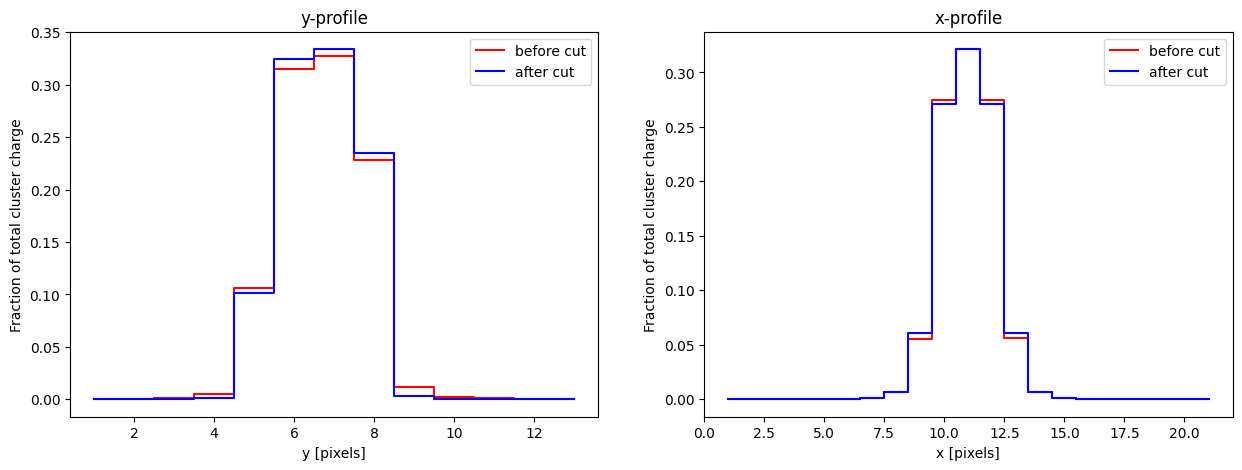

In [48]:
yaxis=np.arange(1,14,1)
xaxis=np.arange(1,22,1)

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].step(yaxis,getAverageYProfile(all_clusters), where="mid", label="before cut", c ='r')
ax[0].step(yaxis,getAverageYProfile(all_remaining_clusters), where="mid", label="after cut", c='b')
ax[0].legend()
ax[0].set_title("y-profile")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

ax[1].step(xaxis,getAverageXProfile(all_clusters), where="mid", label="before cut", c ='r')
ax[1].step(xaxis,getAverageXProfile(all_remaining_clusters), where="mid", label="after cut", c='b')
ax[1].legend()
ax[1].set_title("x-profile")
ax[1].set_ylabel("Fraction of total cluster charge")
ax[1].set_xlabel("x [pixels]")

plt.show()